# Validate proteome of pcFBA

In [1]:
from gurobipy import *

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['svg.fonttype'] = 'none'
pd.set_option('display.max_colwidth', -1)
%matplotlib inline

from cobra.io import load_json_model
from six import iteritems
import numpy as np
import cobra

## Load nominal model

In [2]:
ijomc = load_json_model('/home/laurence/ME/data/dynamicME/nominal_ijomc.json')

## Load fitted keffs

In [3]:
import json

with open('/home/laurence/ME/data/dynamicME/keff_radix/kfit_dict_10.json') as f:
    kfit_dict = json.load(f)

In [4]:
df_meas = pd.read_csv('/home/laurence/ME/data/dynamicME/beg/growth_meas.csv')

ex_rxns = [r for r in df_meas.ex_rxn.unique() if ijomc.reactions.has_id(r)]
df_meas = df_meas[ df_meas.ex_rxn.isin(ex_rxns)]
conds = df_meas.substrate.unique()
df_conds = pd.DataFrame([{'cond':r['substrate'], 'rxn':ex_rxn, 'lb':-10 if r['ex_rxn']==ex_rxn else 0, 'ub':1000., 'obj':0.} for i,r in df_meas.iterrows() for ex_rxn in ex_rxns])
df_conds.loc[ (df_conds.cond=='acetate') & (df_conds.rxn=='EX_ac_e'), 'lb'] = -20

# Compare against naive or partially fit?

In [95]:
#a0 = 1./65./3600
a0 = None

In [96]:
#----------------------------------------
# Starting from basal model
perrs = []
errs_fit = []
errs_unfit = []
csrcs = df_conds.cond.unique()
rows = []
rows_prot = []
for csrc in csrcs:        
    ijofit = load_json_model('/home/laurence/ME/data/dynamicME/nominal_ijomc.json')        
    #--------------------------------------------------
    # Constrain to medium
    df_condi = df_conds[ df_conds.cond==csrc]    
    for i,row in df_condi.iterrows():
        rid = row['rxn']
        rxn = ijofit.reactions.get_by_id(rid)
        rxn.lower_bound = row['lb']
        rxn.upper_bound = row['ub']
    # Get unfit growth rate first
    crowding = ijofit.metabolites.get_by_id('crowding')
    if a0 is not None:
        for rxn in ijofit.metabolites.crowding.reactions:
            rxn._metabolites[crowding] = a0
    ijofit.optimize(solver='gurobi')
    mu_unfiti = ijofit.reactions.BIOMASS_Ec_iJO1366_core_53p95M.x
    
    #--------------------------------------------------
    # Fitted    
    for rid,kfit in iteritems(kfit_dict):
        rxn = ijofit.reactions.get_by_id(rid)
        rxn.add_metabolites({crowding:kfit}, combine=False)
    
    ijofit.optimize(solver='gurobi')
    
    mu_measi = df_meas[ df_meas.substrate==csrc].growth_rate_1_h.iloc[0]
    mu_fiti = ijofit.reactions.BIOMASS_Ec_iJO1366_core_53p95M.x
        
    err0= 100*(mu_unfiti-mu_measi)/mu_measi
    err = 100*(mu_fiti - mu_measi)/mu_measi
    derr= 100*(abs(err)-abs(err0))/abs(err0)
    perrs.append(err)
    errs_unfit.append(mu_unfiti - mu_measi)
    errs_fit.append(mu_fiti - mu_measi)
    print('Cond=%s. mu_meas=%g. mu_sim=%g (unfit=%g, error=%.3g%%). Error=%.3g%% (%.3g%% change)' % (
        csrc, mu_measi, mu_fiti, mu_unfiti, err0, err, derr))
    for i,row in df_condi.iterrows():
        rid = row['rxn']
        rxn = ijofit.reactions.get_by_id(rid)        
        print('\t%s uptake=%g' % (rxn.id, rxn.x))
    
    rows.append({'substrate':csrc, 'mu_fit':mu_fiti, 'mu_unfit':mu_unfiti, 'mu_meas':mu_measi})
    # Save prot abundance
    for rxn in crowding.reactions:                
        conc  = rxn.x / rxn.metabolites[crowding]   # mmol/gDW
        if '_abs' in rxn.id:
            rxn = ijofit.reactions.get_by_id(rxn.id.replace('_abs',''))
        gpr   = rxn.gene_reaction_rule
        genes = ','.join([g.id for g in rxn.genes])
        rows_prot.append({'substrate':csrc, 'rxn':rxn.id, 'gpr':gpr, 'genes':genes, 'conc':conc})

perrs = np.array(perrs)
errs_fit = np.array(errs_fit)
errs_unfit = np.array(errs_unfit)
tot_err = sum(abs(errs_fit))
tot_err0 = sum(abs(errs_unfit))
print("Absolute total error: %g"%(tot_err))
print("Total error change: %g%%"%( 100*(tot_err-tot_err0)/tot_err0  ))
print("Absolute percent error: %g%% -- %g%%"%(min(abs(perrs)), max(abs(perrs))))
print("Mean abs percent error = %g%%"%(np.mean(abs(perrs))))
print("Median abs percent error = %g%%"%(np.median(abs(perrs))))

Cond=glucose. mu_meas=0.74. mu_sim=0.743117 (unfit=0.972909, error=31.5%). Error=0.421% (-98.7% change)
	EX_glc__D_e uptake=-10
	EX_malt_e uptake=0
	EX_man_e uptake=0
	EX_fru_e uptake=0
	EX_gal_e uptake=0
	EX_succ_e uptake=0
	EX_mal__L_e uptake=0
	EX_glyc_e uptake=0
	EX_lac__L_e uptake=0
	EX_ac_e uptake=0
Cond=maltose. mu_meas=0.62. mu_sim=0.862881 (unfit=1.69369, error=173%). Error=39.2% (-77.4% change)
	EX_glc__D_e uptake=0
	EX_malt_e uptake=-6.22534
	EX_man_e uptake=0
	EX_fru_e uptake=0
	EX_gal_e uptake=0
	EX_succ_e uptake=0
	EX_mal__L_e uptake=0
	EX_glyc_e uptake=0
	EX_lac__L_e uptake=0
	EX_ac_e uptake=0.502694
Cond=mannose. mu_meas=0.56. mu_sim=0.662882 (unfit=0.965446, error=72.4%). Error=18.4% (-74.6% change)
	EX_glc__D_e uptake=0
	EX_malt_e uptake=0
	EX_man_e uptake=-10
	EX_fru_e uptake=0
	EX_gal_e uptake=0
	EX_succ_e uptake=0
	EX_mal__L_e uptake=0
	EX_glyc_e uptake=0
	EX_lac__L_e uptake=0
	EX_ac_e uptake=0
Cond=fructose. mu_meas=0.55. mu_sim=0.664529 (unfit=0.969159, error=76.

In [97]:
from scipy import stats

df_results = pd.DataFrame(rows)
dsplot = df_results.melt(['substrate','mu_meas'])
dsplot.loc[dsplot.variable=='mu_fit','model'] = 'Fit'
dsplot.loc[dsplot.variable=='mu_unfit','model'] = 'Unfit'
df_perf = dsplot.groupby('variable').apply(lambda x: pd.Series({
    'mdape':100*np.median(abs(x['value']-x['mu_meas'])/abs(x['mu_meas'])),
    'sse':sum( (x['value']-x['mu_meas'])**2 ),
    'rho':stats.spearmanr(x['mu_meas'],x['value'])[0],
    'r':stats.pearsonr(x['mu_meas'],x['value'])[0]
}))

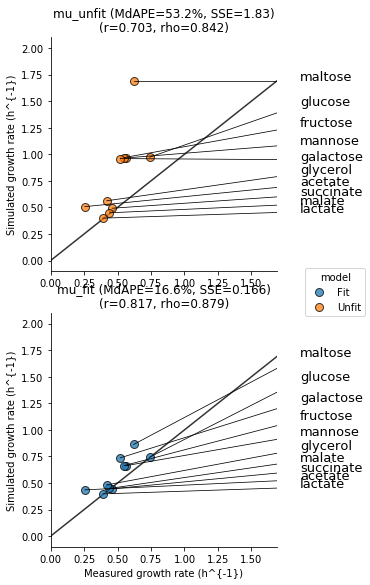

In [98]:
dsplot.variable = dsplot.variable.astype('category')
dsplot.model = dsplot.model.astype('category')
dsplot.variable.cat.reorder_categories(['mu_unfit','mu_fit'], inplace=True)
g = sns.FacetGrid(dsplot, row='variable', hue='model', size=4, aspect=1, sharex=False, sharey=False)
g.map(plt.plot, 'mu_meas','value', linestyle='None', marker='o', markeredgecolor='#000000',lw=0.2, markersize=8, alpha=0.75)
for ax in g.axes.flat:
    ax.plot([0,2],[0,2], zorder=1, color='#333333')
    mdl  = ax.get_title().replace('variable = ','')
    mdape= df_perf.loc[mdl].mdape
    sse  = df_perf.loc[mdl].sse
    r    = df_perf.loc[mdl].r
    rho  = df_perf.loc[mdl].rho    
    ax.set_title('%s (MdAPE=%.3g%%, SSE=%.3g)\n(r=%.3g, rho=%.3g)'%(mdl,mdape, sse, r,rho))
    # Plot text
    dfj = dsplot[ dsplot.variable==mdl]
    #----------------------------------    
    ZERO = 1e-8
    yvar = 'value'
    xvar = 'mu_meas'
    textvar = 'substrate'
    ymin = dsplot[yvar].min() #dfj[yvar].max()*ZERO*1e1
    ymax = dsplot[yvar].max() #ZERO*5e3
    xmax = dsplot[xvar].max()
    xymax = max(xmax,ymax)
    n = len(dfj[textvar].unique())
    k = 0
    for i,row in dfj.sort_values(yvar).iterrows():
        x = row[xvar]
        y = row[yvar] 
        group = row[textvar]
        if x > ZERO and y > ZERO:            
            #incons = abs(x-y)/(x+y) > 0.9
            #if True:
            k += 1
            xx = xymax*1.1
            yy = np.exp(np.log(ymin) + float(k)/n * (np.log(ymax)-np.log(ymin)))
            ax.text(xx, yy, group, color='black', size=13)
            ax.plot([x, xx], [y, yy], lw=0.75, color='black', zorder=2)
            ax.set(xlim=[ZERO, xymax])
    
g.set_xlabels('Measured growth rate (h^{-1})')
g.set_ylabels('Simulated growth rate (h^{-1})')
g.add_legend()

In [99]:
if a0 is None:
    g.savefig('/home/laurence/ME/figures/decomposition/keff_radix/ijo_perf_vs_unfit.svg')
    g.savefig('/home/laurence/ME/figures/decomposition/keff_radix/ijo_perf_vs_unfit.eps')
    g.savefig('/home/laurence/ME/figures/decomposition/keff_radix/ijo_perf_vs_unfit.pdf')
else:
    g.savefig('/home/laurence/ME/figures/decomposition/keff_radix/ijo_perf_vs_naive.svg')
    g.savefig('/home/laurence/ME/figures/decomposition/keff_radix/ijo_perf_vs_naive.eps')
    g.savefig('/home/laurence/ME/figures/decomposition/keff_radix/ijo_perf_vs_naive.pdf')

# Validate proteome abundances

In [20]:
df_schmidt= pd.read_csv('/home/laurence/ME/data/cobrame/sectors/schmidt_prot_mf.csv')

In [35]:
df_schmidt.head()

,Gene,Bnumber,Annotated.functional.COG.groups..letter.,Annotated.functional.COG.group..description.,Annotated.functional.COG.class,Uniprot.Accession,condition,mf
0,rpoC,b3988,K,Transcription,INFORMATION STORAGE AND PROCESSING,P0A8T7,Glucose,0.002941
1,rpoB,b3987,K,Transcription,INFORMATION STORAGE AND PROCESSING,P0A8V2,Glucose,0.004068
2,acnB,b0118,C,Energy production and conversion,METABOLISM,P36683,Glucose,0.004853
3,purL,b2557,F,Nucleotide transport and metabolism,METABOLISM,P15254,Glucose,0.002369
4,gltB,b3212,E,Amino acid transport and metabolism,METABOLISM,P09831,Glucose,0.003187


## Compare proteomes:
- If GPR = OR: sum up measured
- If GPR = AND: compare complex abundance

In [46]:
df_prot_sim = pd.DataFrame(rows_prot)

In [47]:
df_prot_sim.head()

,conc,genes,gpr,rxn,substrate
0,0.0,b0444,b0444,CCGS,glucose
1,0.0,"b0351,b1241",b0351 or b1241,ACALD,glucose
2,0.0,"b2979,b4467,b4468",b2979 and b4467 and b4468,GLYCTO3,glucose
3,0.0,b1109,b1109,NADH9,glucose
4,0.0,b0331,b0331,MCITL2,glucose


In [48]:
df_prot_sim[ df_prot_sim.conc > 0]

,conc,genes,gpr,rxn,substrate
14,2.355190e+06,"b0273,b4254",b4254 or b0273,OCBT,glucose
17,4.895194e+04,b3941,b3941,MTHFR2,glucose
18,7.531585e+04,b0142,b0142,HPPK2,glucose
20,1.130376e+06,"b0241,b0929,b2215,b1377",b0241 or b0929 or b1377 or b2215,NH4tex,glucose
23,9.590592e+05,b0452,b0452,FACOAE161,glucose
25,3.607792e+04,b3642,b3642,ORPT,glucose
26,1.978926e+05,"b2342,b3845",b2342 or b3845,ACACT5r,glucose
38,4.732229e+07,"b2215,b0929,b0241,b1377",b0241 or b0929 or b1377 or b2215,O2tex,glucose
39,1.835512e+02,b3648,b3648,GK1,glucose
42,9.389939e+04,b0096,b0096,UHGADA,glucose
